In [1]:
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn nltk tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Attention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
fake_df = pd.read_csv("Fake.csv")
real_df = pd.read_csv("True.csv")

fake_df['label'] = 0
real_df['label'] = 1

df = pd.concat([fake_df, real_df]).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,title,text,subject,date,label
0,Boiler Room EP #74 – Dustification & The Crook...,Tune in to the Alternate Current Radio Network...,Middle-east,"September 14, 2016",0
1,The GOP Is Sharing Conference Space With PERF...,There are seldom those moments in life that se...,News,"January 17, 2016",0
2,Watch Desperate Americans Literally BEG Justi...,As Canadian Prime Minister Justin Trudeau cont...,News,"March 18, 2016",0
3,Arab coalition says will keep Yemen port open;...,ADEN (Reuters) - The Saudi-led coalition fight...,worldnews,"December 20, 2017",1
4,New Poll Has Clinton Beating Trump By Eleven ...,While the media continues to push the narrativ...,News,"June 3, 2016",0


In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

tqdm.pandas()
df['clean_text'] = df['text'].progress_apply(clean_text)


100%|██████████| 44898/44898 [01:11<00:00, 627.15it/s]


In [5]:
MAX_VOCAB = 20000
MAX_LEN = 200
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B

embeddings_index = {}
with open("glove.6B/glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((MAX_VOCAB, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


--2025-11-02 17:11:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-02 17:11:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-02 17:11:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [7]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        score = K.softmax(K.sum(inputs, axis=2))
        context = K.sum(inputs * K.expand_dims(score), axis=1)
        return context

input_layer = Input(shape=(MAX_LEN,))
embedding_layer = Embedding(MAX_VOCAB, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAX_LEN, trainable=False)(input_layer)
bilstm = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
attention = AttentionLayer()(bilstm)
dense = Dense(64, activation='relu')(attention)
drop = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(drop)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │             0 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,251,009 (8.59 MB)

 Trainable params: 251,009 (980.50 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=128,
    callbacks=[es],
    verbose=1
)


Epoch 1/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.7725 - loss: 0.5103 - val_accuracy: 0.9198 - val_loss: 0.2215
Epoch 2/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.9288 - loss: 0.2110 - val_accuracy: 0.9439 - val_loss: 0.1529
Epoch 3/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9488 - loss: 0.1450 - val_accuracy: 0.9609 - val_loss: 0.1145
Epoch 4/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9630 - loss: 0.1081 - val_accuracy: 0.9628 - val_loss: 0.0997
Epoch 5/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.9704 - loss: 0.0890 - val_accuracy: 0.9751 - val_loss: 0.0691
Epoch 6/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.9787 - loss: 0.0627 - val_accuracy: 0.9705 - val_loss: 0.0788
Epoch 7/8
225/225 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.9775 - loss: 0.0644 - val_accuracy: 0.9802 - val_loss: 0.0600
Epoch 8/8
198/225 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9828 - loss: 0.0512

281/281 ━━━━━━━━━━━━━━━━━━━━ 68s 240ms/step

Classification Report:

              precision    recall  f1-score   support

        Fake       0.98      0.99      0.98      4661
        Real       0.98      0.98      0.98      4319

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



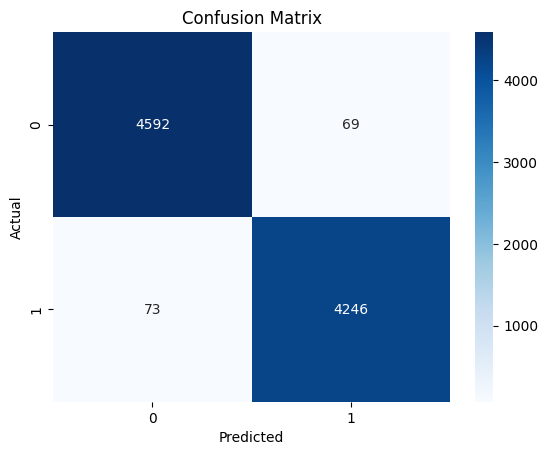

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
